In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022')

In [2]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pickle
import json
import glob
import os
import math

import matplotlib.pyplot as plt
%matplotlib inline


from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import gp_priors

from enterprise_extensions import model_utils, blocks
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise.signals import selections
import enterprise_extensions.chromatic.chromatic


from enterprise_warp import enterprise_warp

import h5py
import la_forge.core as co
import ppta_dr2_models as dr2models

In [3]:
noisefile = '/Users/physics/nanogw/data/ppta_dr2_TN_noise.json'

with open(noisefile, 'r') as f:
    noisedict = json.load(f)

In [4]:
with open('/Users/physics/nanogw/data/ppta_dr2.pkl','rb') as fin:
    psrs=pickle.load(fin)

In [5]:
for psr in psrs: 
    print(psr)

In [6]:
psrsname=[]
for p in psrs:
    psrsname.append(p.name)

print(psrsname)

['J0437-4715', 'J0613-0200', 'J0711-6830', 'J1017-7156', 'J1022+1001', 'J1024-0719', 'J1045-4509', 'J1125-6014', 'J1446-4701', 'J1545-4550', 'J1600-3053', 'J1603-7202', 'J1643-1224', 'J1713+0747', 'J1730-2304', 'J1732-5049', 'J1744-1134', 'J1824-2452A', 'J1832-0836', 'J1857+0943', 'J1909-3744', 'J1939+2134', 'J2124-3358', 'J2129-5721', 'J2145-0750', 'J2241-5236']


In [ ]:
"""
import os
 
# Function to rename multiple files
folder = "/Users/physics/Desktop/paramfilespta/"

p=0

for count, filename in enumerate(sorted(os.listdir(folder))):
    name=psrsname[count]
    add=name
    old=filename
    oldpath=folder+filename
    new=add+'_'+filename[5:] 
    newpath=folder+new
    print(newpath)
         
    # rename() function will
    # rename all the files
    os.rename(oldpath, newpath)
"""

In [ ]:
"""
keys = []
values = []
for k, v in noisedict.items():
    if 'J2241' in k: 
        keys.append(k)
        values.append(noisedict[k])
pulsar_noise=dict(zip(keys, values))
"""

In [ ]:
'''
with open("/Users/physics/Desktop/Noisepta/J2241noisefile.json", "w") as outfile:
    json.dump(pulsar_noise, outfile)
'''

In [7]:
class opts(object):pass
setattr(opts,'extra_model_terms','None')
setattr(opts,'job_config_xlsx',None)
setattr(opts,'num',0)
setattr(opts,'mpi_regime',None)
setattr(opts,'wipe_old_output',None)

In [8]:
len(psrs)

26

In [10]:
noisepath="/Users/physics/Desktop/Noisemodelpta/"
parampath="/Users/physics/Desktop/paramfilespta/"
full_model=[]
models=[]
point=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

params = enterprise_warp.enterprise_warp.Params('/Users/physics/Desktop/ppta_gw/pta.txt', opts=opts)
pulsars = dr2models.PPTADR2Models(psrs,params)

for p in point:
    with open('/Users/physics/Desktop/ppta_gw/pta.json','r') as f:
        model_names = json.load(f)[psrs[p].name]
    model= pulsars.gwb()
    model += pulsars.efac()
    for ky in model_names.keys():
        print(ky)
        if ky != 'efac':
            if ky in ['system_noise','paired_ppta_band_noise','ppta_band_noise','fd_sys_g']:
                model +=getattr(pulsars,ky)(option=model_names[ky])
            else: 
                model += getattr(pulsars,ky)()
                
models.append(model)
full_model.append(model(psr))

------------------
Setting default parameters with file  /Users/physics/Desktop/ppta_gw/pta.txt
Setting default Solar System Ephemeris: DE436
Setting a default Enterprise clock convention (check the code)
Using all available pulsars from .par/.tim directory
Setting a default linear timing model
Including transient events to specific pulsar models
Setting reference radio frequency to 1400 MHz
------------------
Setting sampler kwargs from the parameter file:
Setting SCAMweight to 30
Setting AMweight to 15
Setting DEweight to 50
------------------
Current .par file:  J0437-4715.par
Current .tim file:  J0437-4715.tim
Number of Fourier frequencies for the GWB/CPL signal:  91
Adding HD ORF
efac
equad
ecorr
dm_noise


TypeError: no_selection() missing 1 required positional argument: 'toas'

In [9]:
noisepath="/Users/physics/Desktop/Noisemodelpta/"
parampath="/Users/physics/Desktop/paramfilespta/"
point=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
full_model=[]
models=[]

paramspta = enterprise_warp.enterprise_warp.Params('/Users/physics/Desktop/ppta_gw/pta.txt', opts=opts)
pulsars = dr2models.PPTADR2Models(psrs,paramspta)

for psr,param_file,noise_file,n in zip(psrs,sorted(os.listdir("/Users/physics/Desktop/paramfilespta/")),sorted(os.listdir("/Users/physics/Desktop/Noisemodelpta")),point): 
    model= pulsars.gwb()
    pnm = psr.name
    print(noisepath+noise_file)
    with open(noisepath+noise_file,'r') as f:
        model_names = json.load(f)[pnm]
    opts.num=n
    print(parampath+param_file)
    params = enterprise_warp.enterprise_warp.Params(parampath+param_file, opts=opts)
    pulsar = dr2models.PPTADR2Models(psr,params)
    model += pulsar.efac()
    for ky in model_names.keys():
        print(ky)
        if ky != 'efac':
            if ky in ['system_noise','paired_ppta_band_noise','ppta_band_noise','fd_sys_g']:
                model +=getattr(pulsar,ky)(option=model_names[ky])
            else: 
                model += getattr(pulsar,ky)()
                
    models.append(model)
        
    #with open(f'path/to/pickled/models/{pnm}_model_psr.pkl','wb') as fout:
     #   pickle.dump(full_model,fout)

------------------
Setting default parameters with file  /Users/physics/Desktop/ppta_gw/pta.txt
Setting default Solar System Ephemeris: DE436
Setting a default Enterprise clock convention (check the code)
Using all available pulsars from .par/.tim directory
Setting a default linear timing model
Including transient events to specific pulsar models
Setting reference radio frequency to 1400 MHz
------------------
Setting sampler kwargs from the parameter file:
Setting SCAMweight to 30
Setting AMweight to 15
Setting DEweight to 50
------------------
Current .par file:  J0437-4715.par
Current .tim file:  J0437-4715.tim


FileNotFoundError: [Errno 2] No such file or directory: '/Users/physics/Desktop/paramfilespta/'

In [9]:
##Working Model
noisepath="/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/Noisemodelpta/"
parampath="/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/"
point=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
full_model=[]
models=[]

Tspan = model_utils.get_tspan(psrs)

gw = blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, components=30, gamma_val=4.33, name='gw')
for psr,param_file,noise_file,n in zip(psrs,sorted(os.listdir("/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/")),sorted(os.listdir("/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/Noisemodelpta/")),point): 
    pnm = psr.name
    print(noisepath+noise_file)
    with open(noisepath+noise_file,'r') as f:
        model_names = json.load(f)[pnm]
    opts.num=n
    print(parampath+param_file)
    params = enterprise_warp.enterprise_warp.Params(parampath+param_file, opts=opts)
    pulsar = dr2models.PPTADR2Models(psr,params)
    model = gw
    model += pulsar.efac()
    for ky in model_names.keys():
        print(ky)
        if ky != 'efac':
            if ky in ['system_noise','paired_ppta_band_noise','ppta_band_noise','fd_sys_g']:
                model +=getattr(pulsar,ky)(option=model_names[ky])
            else: 
                model += getattr(pulsar,ky)()
                
    models.append(model)
        
    #with open(f'path/to/pickled/models/{pnm}_model_psr.pkl','wb') as fout:
     #   pickle.dump(full_model,fout)

/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/Noisemodelpta/J0437-4715_noisemodel.json
/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J0437-4715_param_fixed_whitenoise.txt
------------------
Setting default parameters with file  /Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J0437-4715_param_fixed_whitenoise.txt
Setting default Solar System Ephemeris: DE436
Setting a default Enterprise clock convention (check the code)
Using all available pulsars from .par/.tim directory
Setting a default linear timing model
Including transient events to specific pulsar models
Setting reference radio frequency to 1400 MHz
------------------
Setting sampler kwargs from the parameter file:
Setting SCAMweight to 30
Setting AMweight to 15
Setting DEweight to 50
------------------
Current .par file:  J0437-4715.par
Current .tim file:  J0437-4715.tim
efac
equad
spin_noise
dm_noise
j0437_event
fd_sys_g
ppta_band_noise
paired_ppta_band_noise
system_

Current .par file:  J1446-4701.par
Current .tim file:  J1446-4701.tim
efac
equad
spin_noise
dm_noise
/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/Noisemodelpta/J1545-4550_noisemodel.json
/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J1545-4550_param_fixed_whitenoise.txt
------------------
Setting default parameters with file  /Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J1545-4550_param_fixed_whitenoise.txt
Setting default Solar System Ephemeris: DE436
Setting a default Enterprise clock convention (check the code)
Using all available pulsars from .par/.tim directory
Setting a default linear timing model
Including transient events to specific pulsar models
Setting reference radio frequency to 1400 MHz
------------------
Setting sampler kwargs from the parameter file:
Setting SCAMweight to 30
Setting AMweight to 15
Setting DEweight to 50
------------------
Current .par file:  J1545-4550.par
Current .tim file:  J1545-4550.t

Current .par file:  J1824-2452A.par
Current .tim file:  J1824-2452A.tim
efac
equad
spin_noise
dm_noise
paired_ppta_band_noise
/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/Noisemodelpta/J1832-0836_noisemodel.json
/Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J1832-0836_param_fixed_whitenoise.txt
------------------
Setting default parameters with file  /Users/physics/nanogw/Optimal-Statisitic-iPTA-Summer-2022/paramfilespta/J1832-0836_param_fixed_whitenoise.txt
Setting default Solar System Ephemeris: DE436
Setting a default Enterprise clock convention (check the code)
Using all available pulsars from .par/.tim directory
Setting a default linear timing model
Including transient events to specific pulsar models
Setting reference radio frequency to 1400 MHz
------------------
Setting sampler kwargs from the parameter file:
Setting SCAMweight to 30
Setting AMweight to 15
Setting DEweight to 50
------------------
Current .par file:  J1832-0836.par
Current

In [ ]:
#import cloudpickle
#with open('/Users/physics/nanogw/data/ppta_models.pkl','wb') as fout:
 #   cloudpickle.dump(models,fout)

In [10]:
for p in psrs:
    p.name=p.name+'_ppta'
for p in psrs:
    print(p.name)

J0437-4715_ppta
J0613-0200_ppta
J0711-6830_ppta
J1017-7156_ppta
J1022+1001_ppta
J1024-0719_ppta
J1045-4509_ppta
J1125-6014_ppta
J1446-4701_ppta
J1545-4550_ppta
J1600-3053_ppta
J1603-7202_ppta
J1643-1224_ppta
J1713+0747_ppta
J1730-2304_ppta
J1732-5049_ppta
J1744-1134_ppta
J1824-2452A_ppta
J1832-0836_ppta
J1857+0943_ppta
J1909-3744_ppta
J1939+2134_ppta
J2124-3358_ppta
J2129-5721_ppta
J2145-0750_ppta
J2241-5236_ppta


In [11]:
len(models)

26

In [12]:
len(psrs)

26

In [13]:
full_model2=[]
for m,psr in zip(models,psrs):
    full_model2.append(m(psr))

In [14]:
noisefile = '/Users/physics/nanogw/data/ppta_dr2_TN_noise.json'

with open(noisefile, 'r') as f:
    noisedict = json.load(f)

In [15]:
noisedictcp=noisedict.copy()
#for ky,val in noisedict.items():
#    if 'equad'in ky and not 'tnequad' in ky:
#        kynew=ky.replace('equad','tnequad')
#        noisedictcp[kynew] = noisedict[ky]

noisedictcp2=noisedictcp.copy()
for ky,val in noisedictcp.items():
    split=ky.split('_')
    split.insert(1,'ppta')
    kynew='_'.join(split)
    noisedictcp2[kynew] = noisedictcp[ky]
for ky,val in noisedictcp.items():
    if ky in noisedictcp:
        noisedictcp2.pop(ky)

In [16]:
pta = signal_base.PTA(full_model2)
# We need to set the white noise parameters to the values in the noise dictionary
pta.set_default_params(noisedictcp2)

In [17]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

In [28]:
# Load up the maximum-likelihood values for the pulsars' red noise parameters and the common red process
# These values come from the results of a Bayesian search

with open("/Users/physics/nanogw/data/ppta_ml_params.pkl",'rb') as fin:
    ml_params=pickle.load(fin)

ml_paramscp=ml_params.copy()
for ky,val in ml_params.items():
    split=ky.split('_')
    split.insert(1,'ppta')
    kynew='_'.join(split)
    ml_paramscp[kynew] = ml_params[ky]
for ky,val in ml_params.items():
    if ky in ml_params:
        ml_paramscp.pop(ky)
ml_paramscp['gw_log10_A']=ml_paramscp['gw_ppta_log10_A']

In [29]:
ml_paramscp['J0437-4715_ppta_chromatic_gp_idx']=4
ml_paramscp['J0613-0200_ppta_chromatic_gp_idx']=4
ml_paramscp['J1017-7156_ppta_chromatic_gp_idx']=2.39
ml_paramscp['J1045-4509_ppta_chromatic_gp_idx']=1.82
ml_paramscp['J1939+2134_ppta_chromatic_gp_idx']=4

In [30]:
ml_paramscp

{'J0437-4715_ppta_band_noise_7_20CM_gamma': 3.049994802210053,
 'J0437-4715_ppta_band_noise_7_20CM_log10_A': -13.650642385600916,
 'J0437-4715_ppta_band_noise_by_B_4050CM_4050CM_gamma': 1.2868547453651276,
 'J0437-4715_ppta_band_noise_by_B_4050CM_4050CM_log10_A': -13.503948657095098,
 'J0437-4715_ppta_chromatic_gp_gamma': 2.065814974203881,
 'J0437-4715_ppta_chromatic_gp_log10_A': -14.304840939440638,
 'J0437-4715_ppta_dm_gp_gamma': 3.2914690295091478,
 'J0437-4715_ppta_dm_gp_log10_A': -13.587604509820993,
 'J0437-4715_ppta_dmexp_idx': -0.27328321409228395,
 'J0437-4715_ppta_dmexp_log10_Amp': -6.184373208608071,
 'J0437-4715_ppta_dmexp_log10_tau': 1.4560385098541047,
 'J0437-4715_ppta_dmexp_t0': 57061.88085496656,
 'J0437-4715_ppta_fd1_sys_CASPSR_40CM_CASPSR_40CM_slope': 3.92553089435287e-08,
 'J0437-4715_ppta_fd1_sys_CPSR2_50CM_CPSR2_50CM_slope': 9.9817303902494e-08,
 'J0437-4715_ppta_fd1_sys_PDFB1_10CM_PDFB1_10CM_slope': 3.966358356544e-10,
 'J0437-4715_ppta_fd1_sys_PDFB1_1433_PDFB1_

In [23]:
for ky in ml_paramscp.keys():
    if ky not in pta.param_names:
        print(ky)

gw_ppta_log10_A
nmodel_ppta
lnpost_ppta
lnlike_ppta
chain_ppta_accept
pt_ppta_chain_accept


In [24]:
for nm in pta.param_names:
    if nm not in ml_paramscp.keys():
        print(nm)

In [33]:
#ppta_param_names=[]
#for name in ml_paramscp.keys(): 
 #   ppta_param_names.append(name)

In [34]:
#len(ppta_param_names)

183

In [18]:
ppta_param_names=np.loadtxt('/Users/physics/nanogw/data/chains_ppta_dr2/pars.txt',dtype=str)

In [19]:
ppta_param_namescp=[]
for ky in ppta_param_names:
    split=ky.split('_')
    split.insert(1,'ppta')
    kynew='_'.join(split)
    ppta_param_namescp.append(kynew)
idx=ppta_param_namescp.index('gw_ppta_log10_A')
ppta_param_namescp[idx]='gw_log10_A'

In [20]:
ppta_param_namescp

['J0437-4715_ppta_band_noise_7_20CM_gamma',
 'J0437-4715_ppta_band_noise_7_20CM_log10_A',
 'J0437-4715_ppta_band_noise_by_B_4050CM_4050CM_gamma',
 'J0437-4715_ppta_band_noise_by_B_4050CM_4050CM_log10_A',
 'J0437-4715_ppta_chromatic_gp_gamma',
 'J0437-4715_ppta_chromatic_gp_log10_A',
 'J0437-4715_ppta_dm_gp_gamma',
 'J0437-4715_ppta_dm_gp_log10_A',
 'J0437-4715_ppta_dmexp_idx',
 'J0437-4715_ppta_dmexp_log10_Amp',
 'J0437-4715_ppta_dmexp_log10_tau',
 'J0437-4715_ppta_dmexp_t0',
 'J0437-4715_ppta_fd1_sys_CASPSR_40CM_CASPSR_40CM_slope',
 'J0437-4715_ppta_fd1_sys_CPSR2_50CM_CPSR2_50CM_slope',
 'J0437-4715_ppta_fd1_sys_PDFB1_10CM_PDFB1_10CM_slope',
 'J0437-4715_ppta_fd1_sys_PDFB1_1433_PDFB1_1433_slope',
 'J0437-4715_ppta_fd1_sys_PDFB_20CM_PDFB_20CM_slope',
 'J0437-4715_ppta_fd1_sys_PDFB_40CM_PDFB_40CM_slope',
 'J0437-4715_ppta_fd1_sys_WBCORR_10CM_WBCORR_10CM_slope',
 'J0437-4715_ppta_red_noise_gamma',
 'J0437-4715_ppta_red_noise_log10_A',
 'J0437-4715_ppta_system_noise_10_CPSR2_10CM_gamma',


In [21]:
len(pta.param_names)

177

In [22]:
for nm in pta.param_names:
    if nm not in ppta_param_namescp :
        print(nm)

J0437-4715_ppta_chromatic_gp_idx
J0613-0200_ppta_chromatic_gp_idx
J1017-7156_ppta_chromatic_gp_idx
J1045-4509_ppta_chromatic_gp_idx
J1939+2134_ppta_chromatic_gp_idx


In [23]:
len(ppta_param_namescp)

173

In [24]:
type(ppta_param_names)

numpy.ndarray

In [25]:
ppta_array=np.load("/Users/physics/nanogw/data/combined_ppta_chain.npy") 

In [26]:
ppta_array.shape

(1000, 177)

In [41]:
ppta_array[:,-5]

array([0.67142277, 0.59985899, 1.27535791, 1.00623479, 0.5453179 ,
       0.82930489, 0.62434354, 1.37503259, 0.50922305, 1.23540365,
       1.03999186, 0.75132515, 0.709298  , 1.14365677, 1.35894609,
       1.0731537 , 1.27525087, 0.95620792, 0.67275026, 0.9145523 ,
       1.00731438, 1.3438695 , 1.22102327, 1.17124097, 1.17318484,
       1.29405562, 1.4869106 , 0.5078081 , 1.44909456, 0.51346672,
       1.33975729, 0.90878435, 0.67873465, 0.50267422, 1.28354768,
       1.47787628, 0.71708064, 0.88958614, 1.42966808, 0.5133905 ,
       0.85947204, 0.57745564, 1.00196048, 1.19287404, 0.57323353,
       1.16225041, 0.64691516, 1.38857692, 0.9450482 , 0.71708064,
       1.42907817, 1.07677845, 0.83735684, 1.44274474, 0.81391606,
       1.04416469, 1.44811366, 0.52080843, 0.85954415, 1.39723485,
       0.60882039, 0.72524666, 1.20852937, 0.63856231, 0.71458994,
       0.86724139, 1.35460893, 1.05848623, 0.92581971, 1.42173946,
       0.72198012, 1.35210068, 1.21267263, 0.74471804, 0.85378

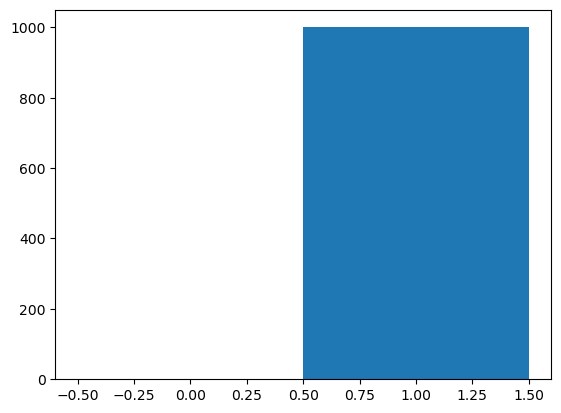

In [45]:
plt.hist(ppta_array[:,-5],bins=[-.5,.5,1.5])
plt.show()

In [25]:
if (np.isnan(ppta_array).any()): 
    print("NAN")

In [26]:
if (np.isinf(ppta_array).any()):
    print("inf")

In [34]:
ahat= []
snr = []
for ii in range(10):
    param =(dict(zip(ppta_param_namescp,ppta_array[ii,:-4])))
    param['J0437-4715_ppta_chromatic_gp_idx']=4
    param['J0613-0200_ppta_chromatic_gp_idx']=4
    param['J1017-7156_ppta_chromatic_gp_idx']=2.39
    param['J1045-4509_ppta_chromatic_gp_idx']=1.82
    param['J1939+2134_ppta_chromatic_gp_idx']=4
    xi, rho, sig, Ahat, Ahat_err = ostat.compute_os(params=param) #HD
    ahat.append(Ahat)
    snr.append(Ahat/Ahat_err)
    print(Ahat/Ahat_err)

23.667734288212184
26.63376408402118
23.281205831568574
34.24876756295425
33.48617277844329
29.279423194332313
32.52753410546741
34.767312935785974
27.224564711776907
24.723121774808792


In [31]:
# Compute the optimal statistic
# The optimal statistic returns five quantities:
#  - xi: an array of the angular separations between the pulsar pairs (in radians)
#  - rho: an array of the cross-correlations between the pulsar pairs
#  - sig: an array of the uncertainty in the cross-correlations
#  - OS: the value of the optimal statistic
#  - OS_sig: the uncertainty in the optimal statistic

xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_paramscp) #HD
print(OS, OS_sig, OS/OS_sig)

_, _, _, OS_dip, OS_sig_dip = ostat_dip.compute_os(params=ml_paramscp) #Dipole
print(OS_dip, OS_sig_dip, OS_dip/OS_sig_dip)

_, _, _, OS_mono, OS_sig_mono = ostat_mono.compute_os(params=ml_paramscp) #Monopole 
print(OS_mono, OS_sig_mono, OS_mono/OS_sig_mono)

2.4092516394079445e-29 8.498926957027876e-31 28.347715559735484
-2.0197167567587715e-30 2.2291549869347873e-31 -9.060459091433543
5.407645422896728e-30 1.3182847793564503e-31 41.020312967101006


In [26]:
pta.get_lnlikelihood(ml_paramscp)

KernelMatrix(1817875.55822771)

In [27]:
ml_params['lnlike']

1895529.812548

In [ ]:
pta.get_lnprior(ml_paramscp)

In [ ]:
Tspan